In [1]:
library(DESeq2)
library(dplyr)
library(ggplot2)
library(tibble)
library(tidyr)
library(ggrepel)  # For non-overlapping text labels

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
deseq_brain = readRDS('../../rds/deseq2_brain_mockvirus.rds')
deseq_gundiff = readRDS('../../rds/deseq2_gut_undiff_mockvirus.rds')
deseq_gdiff = readRDS('../../rds/deseq2_gut_diff_mockvirus.rds')

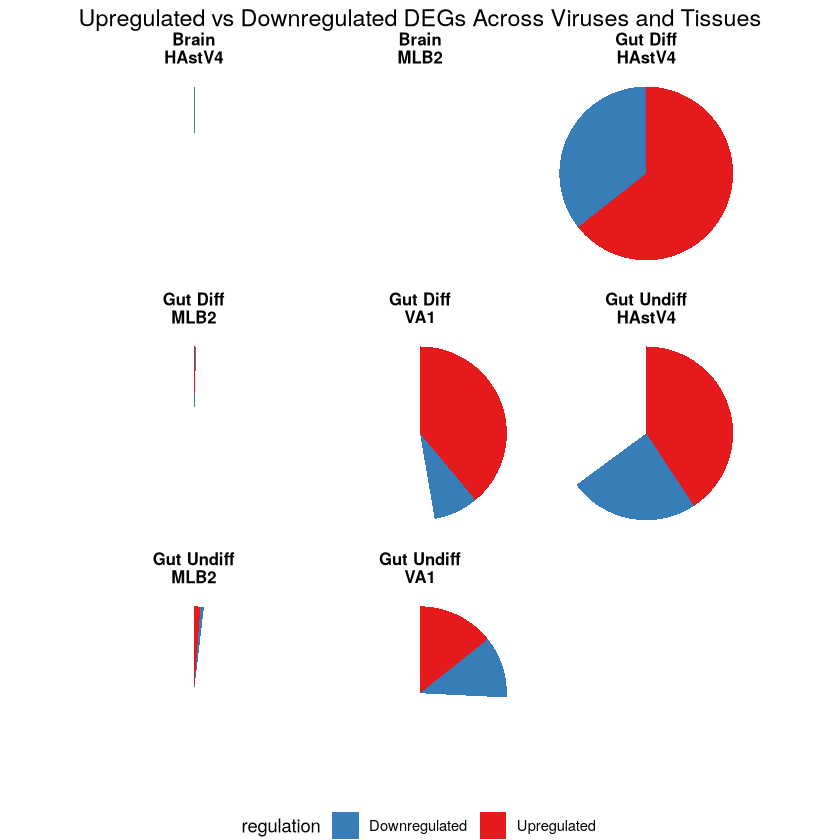

In [5]:
# Helper function to count up/down DEGs
count_up_down <- function(df, virus_name, tissue_name) {
  res <- df %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    filter(!is.na(padj) & padj < 0.05) %>%
    mutate(regulation = ifelse(log2FoldChange > 0, "Upregulated", "Downregulated")) %>%
    count(regulation) %>%
    mutate(virus = virus_name, tissue = tissue_name)
  res$regulation <- as.character(res$regulation)  # Ensure regulation is a character
  return(res)
}

# Collect data for each condition/virus
pie_data <- bind_rows(
  count_up_down(deseq_gundiff$HAstV4, "HAstV4", "Gut Undiff"),
  count_up_down(deseq_gundiff$MLB2, "MLB2", "Gut Undiff"),
  count_up_down(deseq_gundiff$VA1, "VA1", "Gut Undiff"),
  
  count_up_down(deseq_gdiff$HAstV4, "HAstV4", "Gut Diff"),
  count_up_down(deseq_gdiff$MLB2, "MLB2", "Gut Diff"),
  count_up_down(deseq_gdiff$VA1, "VA1", "Gut Diff"),
  
  count_up_down(deseq_brain$HAstV4, "HAstV4", "Brain"),
  count_up_down(deseq_brain$MLB2, "MLB2", "Brain"),
  count_up_down(deseq_brain$VA1, "VA1", "Brain")
)

# Create a combined label for facetting
pie_data$facet_label <- paste0(pie_data$tissue, "\n", pie_data$virus)

# Plot
p <- ggplot(pie_data, aes(x = "", y = n, fill = regulation)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  facet_wrap(~ facet_label, ncol = 3) +
  theme_void() +
  scale_fill_manual(values = c("Upregulated" = "#E41A1C", "Downregulated" = "#377EB8")) +
  labs(title = "Upregulated vs Downregulated DEGs Across Viruses and Tissues") +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 10, face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 14)
  )

# Print
print(p)

# Save if needed
ggsave("DEG_piecharts_all.pdf", p, width = 10, height = 10)
